Le but de ce projet est de proposer un sysème de recommandation de Pokemons.

Création du dossier images

In [ ]:
!mkdir images

Imports

In [19]:
!pip3 install -r requirements.txt

  Using cached https://files.pythonhosted.org/packages/9d/fb/886e8ec7862989afc0c35d15813b6c665fe134cc6027cdde2fa300abe9a2/graphviz-0.19.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/12/05/3350559de9714b202e443a9e6312937341bd5f79f4e4f625744295e7dd17/webcolors-1.11.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c8/89/63171228d5ced148f5ced50305c89e8576ffc695a90b58fe5bb602b910c2/scipy-1.5.4-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/c4/17/3de1cac1ecdb745d36fa33c84c4a1de54b163246374e7d25fe7e77acf967/python_slugify-6.1.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/2d/61/08076519c80041bc0ffa1a8af0cbd3bf3e2b62af10435d269a9d0f40564d/requests-2.27.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/37/45/946c02767aabb873146011e665728b680884cd8fe70dde973c640e45b775/certifi-2021.10.8-py2.py3-none-any.whl
  Using cached https://files.pythonhos

## How to use Kaggle API

### 1st step

Créer un compte sur kaggle.com

### 2nd step

Aller dans Your Profile > Account 
Créer une nouvelle clef d'API

### 3rd step

Déplacer le fichier kaggle.json dans `/fs03/share/users/<current_user>/home/.kaggle`

In [142]:
import kaggle
from PIL import Image
import os, numpy, sys
import matplotlib.pyplot as plot
import math
import json
import random
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import graphviz
import pydotplus
import csv
import webcolors

In [199]:
PATH_TO_IMAGES = "./images/pokemon/pokemon"
EXTENSIONS = [".jpeg", ".png", ".jpg"]
LOCATION = ["Kant", "Johto", "Hoenn", "Sinnoh", "Unys", "Kalos", "Alola", "Galar"]
NB_USERS = 20 # nombre d'utilisteur avec un comportement prédéfini à créer
NB_POKEMONS = 200 # nombre de pokemon a traiter
RATIO_DATASET = .67 # Split data into two dataset (learn, test)

In [26]:
# Récupération du dataset
kaggle.api.authenticate()

kaggle.api.dataset_download_files('kvpratama/pokemon-images-dataset', path='./images', unzip=True)

KeyboardInterrupt: 

In [27]:
# Récupération du csv avec les types

# Ouverture du csv
file = open('images/pokemon.csv')
csvreader = csv.reader(file)

# Ajouter les données dans le tableau "pokemons_csv"
pokemons_csv = []
for row in csvreader:
        pokemons_csv.append(row)


In [85]:
# Pokemon type encoder

# Création d'une "enum" pour les types pour éviter le labelEncoder, 
# ça nous permet de ne pas avoir tous les types dans un dataset
POKEMON_TYPES = ["", "Normal", "Fire", "Water", "Grass", "Flying", "Fighting", "Poison", "Electric", "Ground", "Rock", "Psychic", "Ice", "Bug", "Ghost", "Steel", "Dragon", "Dark", "Fairy"]

# récupérer le nom du type en fonction de l'index
def index_to_type_name(index: int) -> str:
    return POKEMON_TYPES[index]

# récupérer l'index du type en fonction de son nom
def name_to_type_index(name: str) -> int:
    return int(POKEMON_TYPES.index(name))

In [39]:
# Colors encoder

# Même prinicipe qu'avec les types

from scipy.spatial import KDTree
from webcolors import (
    CSS3_HEX_TO_NAMES,
    hex_to_rgb,
)

# Création d'une "enum" pour les types pour éviter le labelEncoder
color_names = []
for color_hex, color_name in CSS3_HEX_TO_NAMES.items():
    color_names.append(color_name)

# récupérer le nom de la couleur en fonction de l'index
def index_to_name(index):
    return names[index]

# récupérer l'index de la couleur en fonction d'une représentation hexadecimal
def convert_hex_to_index(my_color_hex):
    rgb_values = []    
    rgb_tuple = hex_to_rgb(my_color_hex)
    
    for color_hex, color_name in CSS3_HEX_TO_NAMES.items():
        rgb_values.append(hex_to_rgb(color_hex))
    
    # Permet de récupérer le nom de la couleur la plus proche 
    kdt_db = KDTree(rgb_values)    
    _, index = kdt_db.query(rgb_tuple)
    return int(index)

In [40]:
numpy.set_printoptions(threshold=sys.maxsize)

def get_dominant_colors(imgfile):
    numarray = numpy.array(imgfile.getdata(), numpy.uint8)
    # Filtrage du "fond" des png
    numarray = numarray[numarray[:,3] > 0]
    clusters = KMeans(n_clusters = 4)
    clusters.fit(numarray)
    npbins = numpy.arange(0, 5)
    histogram = numpy.histogram(clusters.labels_, bins=npbins)
    # Tri des couleus par fréquence
    sorted_histogram = numpy.sort(histogram[0].astype(numpy.int))[::-1]

    dominant_colors = []
    for i in range(4):
        # On récupère l'index la couleur (convert_hex_to_index)
        dominant_colors.append(convert_hex_to_index('#%02x%02x%02x' % (
        math.ceil(clusters.cluster_centers_[i][0]), 
            math.ceil(clusters.cluster_centers_[i][1]),
        math.ceil(clusters.cluster_centers_[i][2]))))
    return dominant_colors

In [200]:
import re

# Génération des exifs du dataset. Leur région sont choisis au hasard
metadataJSON = {}
i = 0
for filename in os.listdir(PATH_TO_IMAGES):
    for extension in EXTENSIONS:
        if filename.endswith(extension):
            pokemon_csv = pokemons_csv[int(re.findall("\d+", filename)[0])]
            imgfile = Image.open(PATH_TO_IMAGES + "/" + filename)
            imgfile.convert("RGBA")
            colors = get_dominant_colors(imgfile)
            if imgfile.width == imgfile.height:
                orientation = "square"
            elif imgfile.width > imgfile.height:
                orientation = "landscape"
            else:
                orientation = "portrait"
            metadataJSON[pokemon_csv[0]] = {
                "path": filename,
                "size" : imgfile.size,
                "format" : extension,
                "orientation" : orientation,
                # "liked" : random.uniform(0, 1) < 0.4,
                "color_0" : colors[0],
                "color_1" : colors[1],
                "color_2" : colors[2],
                "color_3" : colors[3],
                "type_1" : name_to_type_index(pokemon_csv[1]),
                "type_2" : name_to_type_index(pokemon_csv[2] if len(pokemon_csv) == 3 else ""),
                "location" : random.choice(LOCATION)
            }
            break
    if i < NB_POKEMONS:
        i += 1
    else:
        break
            
with open("metadata.json", "w") as jsonFile:
    jsonFile.write(json.dumps(metadataJSON, indent=4))

### Comment prévoyez-vous de traiter ces tags ? Est-il possible d'automatiser ce processus ?

On peut automatiser ce processus en demandant à des internautes de tagger les images via un site web (site web dédié au tag d'images ou via des captcha).

## Analyse de données

Demandez à l'utilisateur de sélectionner quelques images et d'ajouter des balises. Pour chaque utilisateur, vous êtes
maintenant prêt à construire un profil de préférences d'utilisateur, basé sur cette sélection.
Vous pouvez recueillir les informations suivantes manuellement, mais l'objectif de
cette tâche consiste à les obtenir en utilisant les images sélectionnées de manière automatisée : 

1.  Couleurs préférées
2.  Orientation de l'image préférée
3.  Tailles d'images préférées (vignettes, grandes images, images de taille moyenne
    images, etc.)
4.  Balises favorites
5.  \...

Maintenant, grâce à votre connaissance des différents types de classificateurs et
les algorithmes de regroupement, quelles informations supplémentaires ajouterez-vous pour chaque
image ?

Votre prochain objectif est d'analyser les informations des utilisateurs et leur
les images préférées. Comment avez-vous créé des utilisateurs aléatoires ? Combien d'utilisateurs avez-vous
créer ? Quelles informations avez-vous stockées pour chaque utilisateur ? Quels types d'analyses avez-vous effectuées ?

In [201]:
# Sépration des datasets
file = open("metadata.json")
data = json.load(file)

# Séparation learn
data_learn = dict(list(data.items())[:int(NB_POKEMONS * RATIO_DATASET)])
# Séparation test
data_test = dict(list(data.items())[(int(NB_POKEMONS * RATIO_DATASET) + 1):])

In [202]:
# Création des profil utilisateurs
users = []

# Création d'un pattern avec du bruit pour ne pas trop lisser les données
def does_like(image):
    like = image["type_1"] == 2 or image["type_2"] == 2
    like = like if random.uniform(0, 1) < .9 else not like
    return like

# Pour chaque utilisateurs on va stocker sa couleur préférée et si il a aimé l'image ou non
for i in range(NB_USERS):
    user = {
        'id' : i,
        'images' : [],
        'images_pred': {}
    }
    # Génération des données d'image pour apprendre
    for key, image in data_learn.items():
        colors = [image['color_0'], image['color_1'], image['color_2'], image['color_3']]
        sample = {
            'id_image' : key,
            'favorite_color' : colors[0],
            'like' : does_like(image)
        }
        user['images'].append(sample)
    
    # Génération des données d'image pour tester
    for key, image in data_test.items():
        colors = [image['color_0'], image['color_1'], image['color_2'], image['color_3']]
        sample = {
            'id_image' : key,
            'favorite_color' : colors[0],
            'like' : does_like(image)
        }
        user['images_pred'][key] = sample
    users.append(user)
    

#### Visualisation des données

Dans cette tâche, votre objectif est de visualiser les différentes caractéristiques de
toutes les images téléchargées.

1.  Le nombre d'images disponibles pour chaque année (ici pour chaque __type de pokemons et chaque localisation__)
2.  Le nombre d'images disponibles pour les différents types : taille de l'image,
    l'orientation des images, les modèles d'appareils photo, etc. 
3.  Caractéristiques des couleurs


        path        size format orientation  color_0  color_1  color_2  \
0    269.png  [256, 256]   .png      square       96      120        7   
1    681.png  [256, 256]   .png      square      127       34       49   
2    152.png  [256, 256]   .png      square      100       49        7   
3    688.png  [256, 256]   .png      square       39       45      106   
4    714.png  [256, 256]   .png      square       34      120        7   
..       ...         ...    ...         ...      ...      ...      ...   
129  339.png  [256, 256]   .png      square      120        7       17   
130    6.png  [256, 256]   .png      square       31        7       21   
131   84.png  [256, 256]   .png      square       49        7      127   
132  383.png  [256, 256]   .png      square       49       66        7   
133  411.png  [256, 256]   .png      square       49       39       66   

     color_3  type_1  type_2 location  
0         25      13       7    Hoenn  
1         77      15      14   

<AxesSubplot:title={'center':'Pokemon per type 2'}, xlabel='type_2'>

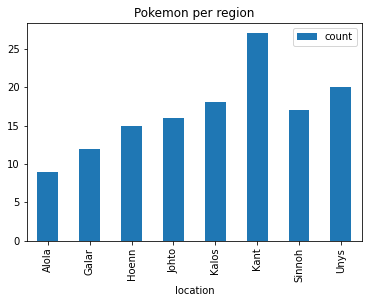

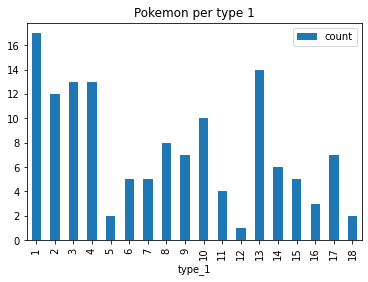

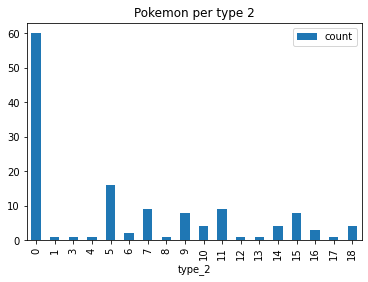

In [203]:
# Convertir en dataframe
dataframe = pd.DataFrame(data_learn.values())

print(dataframe)

# Group by location
dataframe_location = dataframe[['location', 'size']]
grouped_by_location = dataframe_location.groupby('location').count()
grouped_by_location = grouped_by_location.rename(columns={'size':'count'}).reset_index()
grouped_by_location.plot(x=0, kind='bar', title="Pokemon per region")

# Grouped by type 1
dataframe_type_1 = dataframe[['type_1', 'size']]
grouped_by_types = dataframe_type_1.groupby('type_1').count()
grouped_by_types = grouped_by_types.rename(columns={'size':'count'}).reset_index()
grouped_by_types.plot(x=0, kind='bar', title="Pokemon per type 1")


# Grouped by type 2
dataframe_type_2 = dataframe[['type_2', 'size']]
grouped_by_types = dataframe_type_2.groupby('type_2').count()
grouped_by_types = grouped_by_types.rename(columns={'size':'count'}).reset_index()
grouped_by_types.plot(x=0, kind='bar', title="Pokemon per type 2")


Les utilisateurs peuvent également visualiser les informations ci-dessus relatives à leurs images préférées. Dans cette tâche, vous devez également ajouter une fonctionnalité permettant aux utilisateurs de visualiser les informations liées à leur propre profil d'utilisateur.

In [204]:
id_user = -1
while id_user < 0 or id_user > NB_USERS - 1:
    id_user = int(input("Entrez un ID utilisateur (max : " + str(NB_USERS - 1) + ") :"))
    
user_data = users[id_user]
user_df = pd.DataFrame(user_data["images"])
user_df

Entrez un ID utilisateur (max : 19) :4


,id_image,favorite_color,like
0,dustox,96,False
1,aegislash-blade,127,False
2,chikorita,100,False
3,binacle,39,True
4,noibat,34,False
...,...,...,...
129,barboach,120,False
130,charizard,31,True
131,doduo,49,False
132,groudon,49,True


#### Système de recommandation

Êtes-vous maintenant prêt à recommander des images à un utilisateur ? Dans cette tâche, votre objectif est de construire le système de recommandation. Quelle approche avez-vous décidé de prendre ? Filtrage collaboratif, basé sur le contenu ou une approche hybride ? Pour chaque utilisateur, êtes-vous maintenant en mesure de construire une profil ? Quel type d'information avez-vous utilisé pour établir un profil d'utilisateur profil ? Qu'est-ce qui manque ? Quelles sont les limites de votre proposition ?

/fs03/share/users/baptiste.lazareth/home/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/fs03/share/users/baptiste.lazareth/home/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


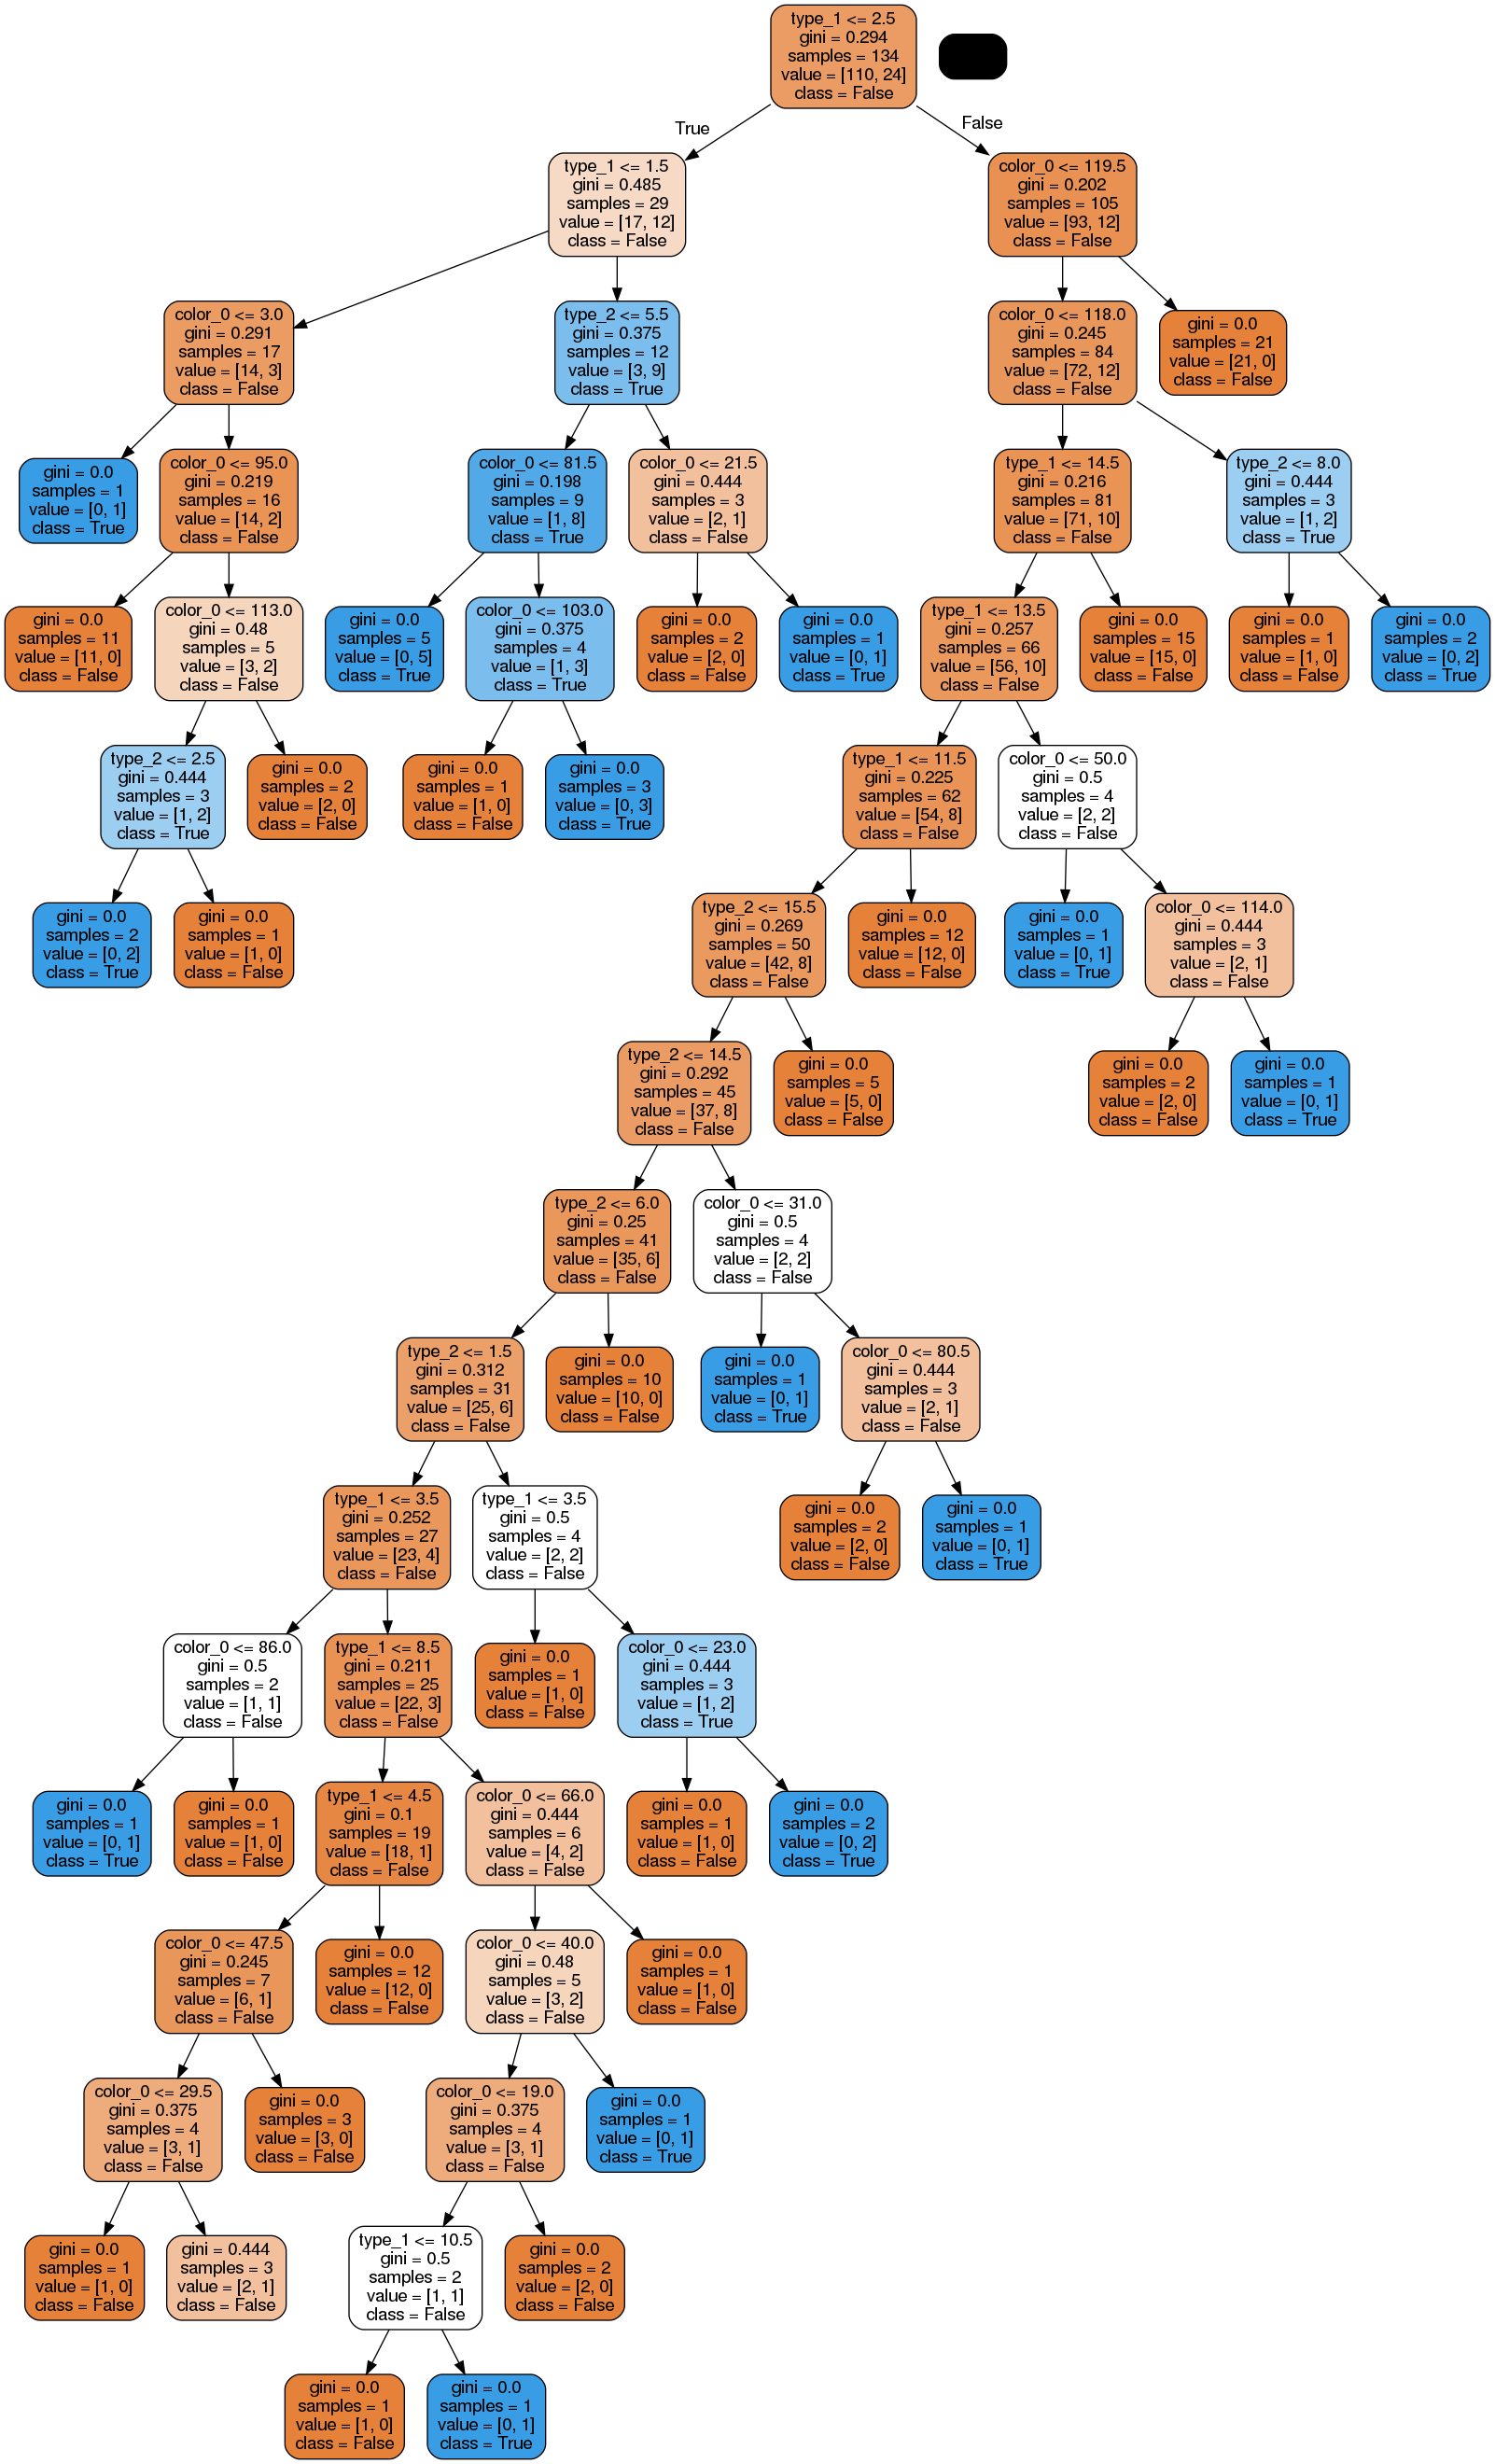

In [206]:
import IPython

resultFrame = user_df[["like"]]
resultFrame["like"] = resultFrame["like"].astype(str)
dataframe_learn = pd.DataFrame(data_learn.values())
df = dataframe_learn[["color_0", "type_1", "type_2"]]


def generate_label(dataframe, column_name):
    le = LabelEncoder()
    dataframe[column_name] = le.fit_transform(dataframe[column_name])
    return le

# generating label
le4 = generate_label(resultFrame, "like")

# Use of decision tree classifiers
dtc = tree.DecisionTreeClassifier()
dtc = dtc.fit(df, resultFrame)

#Use of random forest classifier
rfc = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=0)
rfc = rfc.fit(df, resultFrame.values.ravel())


dot_data = tree.export_graphviz(dtc, out_file=None,
          feature_names=df.columns,
          filled=True, rounded=True, 
          class_names =
          le4.inverse_transform(
            resultFrame.like.unique())
         ) 
graph = graphviz.Source(dot_data) 

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
img = IPython.display.Image(pydot_graph.create_png())
IPython.display.display(img)

In [207]:
tot = len(data_test.keys())
n_true = 0

# Prediction
prediction_df = []
for key, image in data_test.items():
    prediction = rfc.predict([
        [image["color_0"], image["type_1"], image["type_2"]]
    ])
    # Comparer le résultat de la prédiction avec ce que l'utilisateur a vraiment aimé ou pas 
    if str(user['images_pred'][key]["like"]) == str(le4.inverse_transform(prediction)[0]):
        n_true += 1

print("IOU: ", (n_true / tot) * 100, "%")

IOU:  81.9672131147541 %


The user liked :


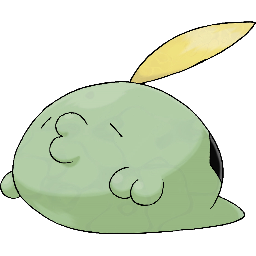

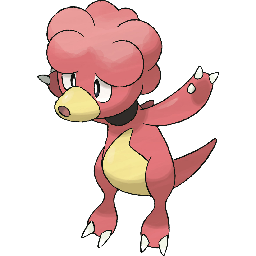

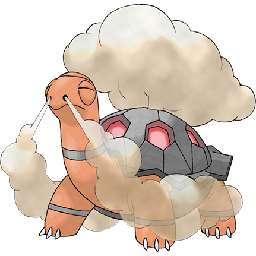

The user might like :


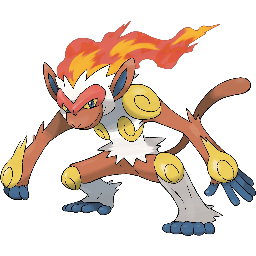

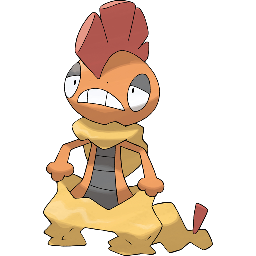

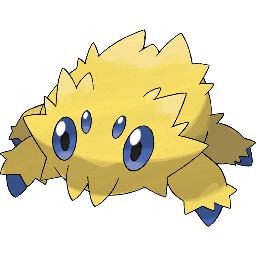

In [209]:
# On montre 3 images qu'il a like et une image qu'on a prédit comme like

liked_images = filter(lambda image: image["like"] == True, user['images'])
will_like_images = filter(lambda image: image["like"] == True, user['images_pred'].values())

r = random.choices(list(liked_images), k=3)
r_will = random.choices(list(will_like_images), k=3)

print("The user liked :")
for i in range(len(r)):
    im = IPython.display.Image(PATH_TO_IMAGES + "/" + data[r[i]['id_image']]['path'])
    IPython.display.display(im)

print("The user might like :")    
for i in range(len(r)):
    im = IPython.display.Image(PATH_TO_IMAGES + "/" + data[r_will[i]['id_image']]['path'])
    IPython.display.display(im)